In [4]:
import pandas as pd
import numpy as np
import random
import os

import pickle

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## 파일명

In [8]:
name = '0323-stratify-2'

In [9]:
# 'Industry_Status',
# 'Hispanic_Origin',
# 'Household_Status',
# 'Birth_Country',
# 'Birth_Country (Father)', 
# 'Birth_Country (Mother)'

In [10]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [11]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

### modify age

In [12]:
# def modify_age(age):
#     if age < 15:
#         return 0
#     elif age < 25:
#         return 1
#     elif age < 40:
#         return 2
#     elif age < 50:
#         return 3
#     elif age < 65:
#         return 4
#     elif age < 80:
#         return 5
#     else:
#         return 6

In [13]:
# train['Age'] = train['Age'].apply(modify_age)
# test['Age'] = test['Age'].apply(modify_age)

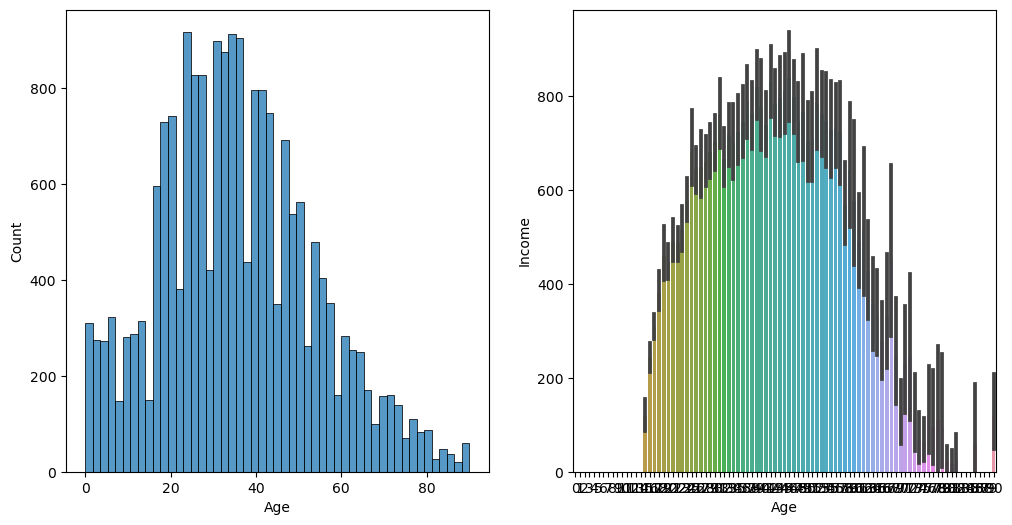

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='Age', data=train)

plt.subplot(1, 2, 2)
sns.barplot(x='Age', y='Income', data=train)
plt.show()

### modify education

In [15]:
def modify_education(education):
    if education in ['Children', 'Kindergarten', 'Elementary (1-4)', 'Elementary (5-6)', 
                     'Middle (7-8)', 'High Freshman', 'High Sophomore', 
                     'High Junior', 'High Senior']:
        return 'dropout'
    elif education in ['College', 'Associates degree (Academic)', 'Associates degree (Vocational)']:
        return 'CommunityCollege'
    elif education in ['Professional degree', 'Masters degree']:
        return 'Masters degree'
    else:
        return education

In [16]:
train['Education'] = train['Education_Status']
train['Education'] = train['Education'].apply(modify_education)

In [17]:
test['Education'] = test['Education_Status']
test['Education'] = test['Education'].apply(modify_education)

### household/tax

### modify household

In [18]:
np.unique(train['Household_Summary'])

array(['Child 18 or older', 'Child under 18 ever married',
       'Child under 18 never married',
       'Group Quarters- Secondary individual', 'Householder',
       'Nonrelative of householder', 'Other relative of householder',
       'Spouse of householder'], dtype=object)

In [19]:
def modify_household(household):
    if household == 'Householder':
        return 'Householder'
    elif household in ['Child 18 or older', 'Child under 18 ever married', 'Child under 18 never married', 
                     'Other relative of householder', 'Spouse of householder']:
        return 'dependents'
    else:
        return 'others'

In [20]:
train['Household_Summary'] = train['Household_Summary'].apply(modify_household)
test['Household_Summary'] = test['Household_Summary'].apply(modify_household)

### modify tax status

In [21]:
def modify_tax(tax):
    if tax.startswith('Married'):
        return 'MFJ'
    else:
        return tax

In [22]:
train['Tax_Status'] = train['Tax_Status'].apply(modify_tax)
test['Tax_Status'] = test['Tax_Status'].apply(modify_tax)

<Axes: xlabel='Count', ylabel='Tax_Status'>

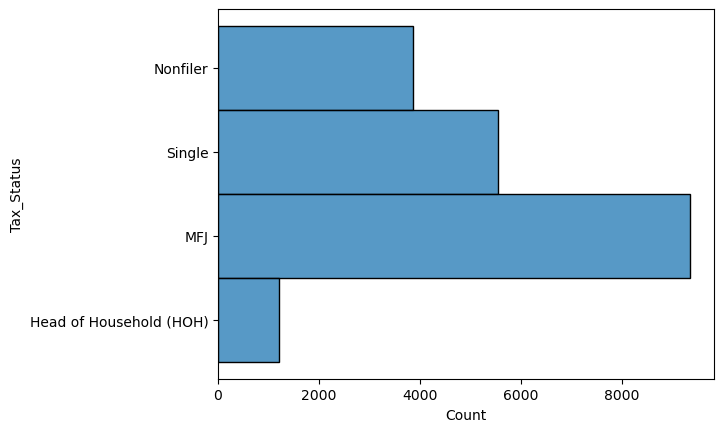

In [23]:
sns.histplot(y='Tax_Status', data=train)

### modify income status

In [24]:
def modify_income_status(status):
    if status in ['Unknown', 'Under Median']:
        return 'Under Median'
    else:
        return status

In [25]:
train['Income_Status'] = train['Income_Status'].apply(modify_income_status)
test['Income_Status'] = test['Income_Status'].apply(modify_income_status)

### working week

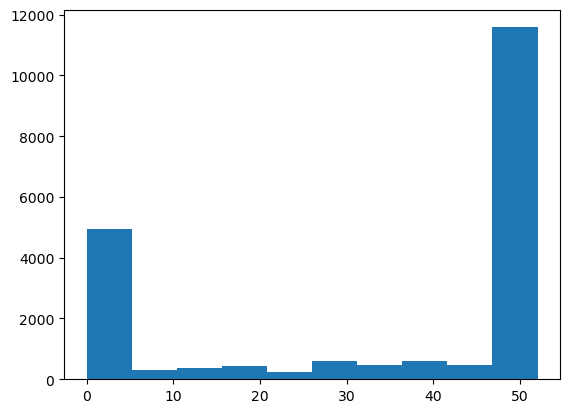

In [26]:
plt.hist(train['Working_Week (Yearly)'])
plt.show()

In [27]:
sum(train['Working_Week (Yearly)']<52), sum(train['Working_Week (Yearly)']==52)

(9387, 10613)

In [28]:
train['Working_Week (Yearly)'] = np.where(train['Working_Week (Yearly)']<52, 0, 1)
test['Working_Week (Yearly)'] = np.where(test['Working_Week (Yearly)']<52, 0, 1)

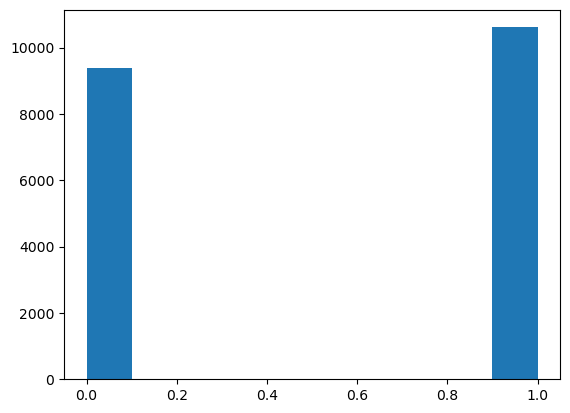

In [29]:
plt.hist(train['Working_Week (Yearly)'])
plt.show()

### gain, loss, dividend

In [30]:
# train['Gains'] = np.where(train['Gains']>0, 1, 0)
# test['Gains'] = np.where(test['Gains']>0, 1, 0)

# train['Losses'] = np.where(train['Losses']>0, 1, 0)
# test['Losses'] = np.where(test['Losses']>0, 1, 0)

# train['Dividends'] = np.where(train['Dividends']>0, 1, 0)
# test['Dividends'] = np.where(test['Dividends']>0, 1, 0)

In [31]:
train['Capital'] = train['Gains'] + train['Dividends'] - train['Losses']
test['Capital'] = test['Gains'] + test['Dividends'] - test['Losses']

train['Capital'] = np.where(train['Capital']>0, 1, 0)
test['Capital'] = np.where(test['Capital']>0, 1, 0)

## main

In [32]:
trainval_x = train.drop(columns=['ID', 'Income', 
                                #  'Industry_Status',
                                 'Hispanic_Origin', 
                                 'Household_Status', 
                                 'Birth_Country', 
                                 'Birth_Country (Father)', 'Birth_Country (Mother)',
                                 'Education_Status',
                                 'Gains', 'Losses', 'Dividends'
                                 ])

trainval_y = train['Income']
# income_over = train['Income'] > 875
# trainval_y = np.log(train['Income']+1)

test_x = test.drop(columns=['ID',
                            # 'Industry_Status',
                            'Hispanic_Origin', 
                            'Household_Status', 
                            'Birth_Country', 
                            'Birth_Country (Father)', 'Birth_Country (Mother)',
                            'Education_Status',
                            'Gains', 'Losses', 'Dividends'
                            ])

In [33]:
def income_cat(income):
    if income == 0:
        return 0
    elif income <= 875:
        return 1
    else:
        return 2

In [34]:
income_cat = train['Income'].apply(income_cat)

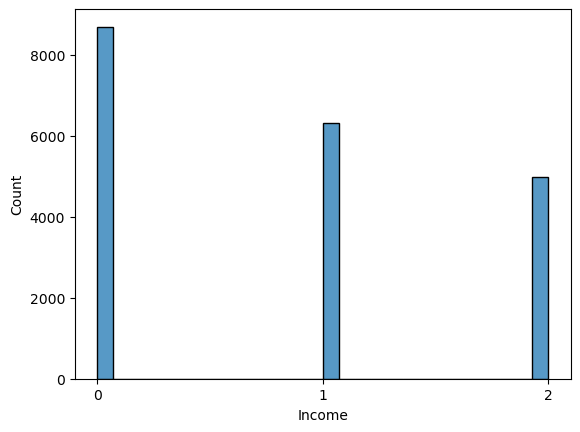

In [35]:
sns.histplot(income_cat)
plt.xticks(np.arange(3))
plt.show()

In [36]:
trainval_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    20000 non-null  int64 
 1   Gender                 20000 non-null  object
 2   Employment_Status      20000 non-null  object
 3   Working_Week (Yearly)  20000 non-null  int32 
 4   Industry_Status        20000 non-null  object
 5   Occupation_Status      20000 non-null  object
 6   Race                   20000 non-null  object
 7   Martial_Status         20000 non-null  object
 8   Household_Summary      20000 non-null  object
 9   Citizenship            20000 non-null  object
 10  Tax_Status             20000 non-null  object
 11  Income_Status          20000 non-null  object
 12  Education              20000 non-null  object
 13  Capital                20000 non-null  int32 
dtypes: int32(2), int64(1), object(11)
memory usage: 2.0+ MB


In [37]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

save_encoder = None
for i in encoding_target:
    le = LabelEncoder()

    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)
    
    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            print('case')
            le.classes_ = np.append(le.classes_, case)
    
    test_x[i] = le.transform(test_x[i])

    if i == 'Occupation_Status':
        save_encoder = le
        print(f'{i}_save')

    if len(np.unique(trainval_x[i])) == 2:
        print(i)
        continue

    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') ## ignore로 학습 데이터셋에 없는 데이터가 들어와도 무시
    train_encoded = ohe.fit_transform(trainval_x[[i]])

    train_encoded_df = pd.DataFrame(train_encoded, columns=[f"{i}_{j}" for j in range(train_encoded.shape[1])])
    trainval_x = pd.concat([trainval_x.drop(columns=[i]), train_encoded_df], axis=1)
    
    test_encoded = ohe.transform(test_x[[i]])
    
    test_encoded_df = pd.DataFrame(test_encoded, columns=[f"{i}_{j}" for j in range(test_encoded.shape[1])])
    test_x = pd.concat([test_x.drop(columns=[i]), test_encoded_df], axis=1)

Gender
Occupation_Status_save
Income_Status


In [38]:
trainval_x.head()

,Age,Gender,Working_Week (Yearly),Income_Status,Capital,Employment_Status_0,Employment_Status_1,Employment_Status_2,Employment_Status_3,Employment_Status_4,...,Tax_Status_0,Tax_Status_1,Tax_Status_2,Tax_Status_3,Education_0,Education_1,Education_2,Education_3,Education_4,Education_5
0,63,1,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,37,1,1,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,58,0,1,1,1,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,44,1,1,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,37,0,1,1,0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### 학습

### oversampling

In [39]:
# trainval_x_sub = trainval_x.iloc[np.where(trainval_y>1200)[0]]
# trainval_y_sub = trainval_y[np.where(trainval_y>1200)[0]]
# income_cat_sub = income_cat[np.where(trainval_y>1200)[0]]

# trainval_x = pd.concat([trainval_x, trainval_x_sub], axis=0)
# trainval_y = pd.concat([trainval_y, trainval_y_sub], axis=0)
# income_cat = pd.concat([income_cat, income_cat_sub], axis=0)

In [40]:
# len(trainval_x), len(trainval_y), len(income_cat)

In [41]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [42]:
model_path = f'models/{name}'
os.makedirs(model_path, exist_ok=True)

In [43]:
num_fold = 1
total_train_error_gbr, total_val_error_gbr = 0, 0
total_train_error_rf, total_val_error_rf = 0, 0
total_train_error_mlp, total_val_error_mlp = 0, 0
test_preds = []
# for train_idx, val_idx in kf.split(trainval_x, income_over):
for train_idx, val_idx in kf.split(trainval_x, income_cat):
    train_x = trainval_x.iloc[train_idx]
    train_y = trainval_y.iloc[train_idx]
    # print(train_x.shape)

    val_x = trainval_x.iloc[val_idx]
    val_y = trainval_y.iloc[val_idx]

    fold_train_y_preds = []
    fold_val_y_preds = []

    ## gbr
    gbr = GradientBoostingRegressor(max_depth=4)
    gbr.fit(train_x, train_y)

    # with open(f'{model_path}/gbr_{num_fold}.pkl', 'wb') as f:
    #     pickle.dump(gbr, f)

    train_y_hat_gbr = gbr.predict(train_x)
    val_y_hat_gbr = gbr.predict(val_x)

    fold_train_y_preds.append(train_y_hat_gbr)
    fold_val_y_preds.append(val_y_hat_gbr)

    pred_gbr = gbr.predict(test_x)

    test_preds.append(pred_gbr)

    train_error = mean_squared_error(train_y, train_y_hat_gbr) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat_gbr) ** 0.5

    total_train_error_gbr += train_error
    total_val_error_gbr += val_error

    print(f'[gbr] train error : {train_error:.2f} | val error : {val_error:.2f}')
    ####
    
    rf = RandomForestRegressor(max_depth=10)
    rf.fit(train_x, train_y)

    # with open(f'{model_path}/rf_{num_fold}.pkl', 'wb') as f:
    #     pickle.dump(rf, f)

    train_y_hat_rf = rf.predict(train_x)
    val_y_hat_rf = rf.predict(val_x)

    fold_train_y_preds.append(train_y_hat_rf)
    fold_val_y_preds.append(val_y_hat_rf)

    pred_rf = rf.predict(test_x)

    test_preds.append(pred_rf)

    train_error = mean_squared_error(train_y, train_y_hat_rf) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat_rf) ** 0.5

    total_train_error_rf += train_error
    total_val_error_rf += val_error

    print(f'[rf] train error : {train_error:.2f} | val error : {val_error:.2f}')
    ###

    # mlp = MLPRegressor(activation='tanh', max_iter=500) # early_stopping
    # mlp.fit(train_x, train_y)

    # with open(f'{model_path}/mlp_{num_fold}.pkl', 'wb') as f:
    #     pickle.dump(mlp, f)

    # train_y_hat_mlp = mlp.predict(train_x)
    # val_y_hat_mlp = mlp.predict(val_x)

    # fold_train_y_preds.append(train_y_hat_mlp)
    # fold_val_y_preds.append(val_y_hat_mlp)

    # pred_mlp = mlp.predict(test_x)

    # test_preds.append(pred_mlp)

    # train_error = mean_squared_error(train_y, train_y_hat_mlp) ** 0.5
    # val_error = mean_squared_error(val_y, val_y_hat_mlp) ** 0.5

    # total_train_error_mlp += train_error
    # total_val_error_mlp += val_error

    # print(f'[mlp] train error : {train_error:.2f} | val error : {val_error:.2f}')

    fold_train_y_hat = np.array(fold_train_y_preds).mean(0)
    fold_val_y_hat = np.array(fold_val_y_preds).mean(0)
    
    train_error = mean_squared_error(train_y, fold_train_y_hat) ** 0.5
    val_error = mean_squared_error(val_y, fold_val_y_hat) ** 0.5

    print(f'[mean] train error : {train_error:.2f} | val error : {val_error:.2f}')    
    print('-'*50)

    # feature_importances = model.feature_importances_
    # importance_df = pd.Series(feature_importances[:20], index=trainval_x.columns[:20])
    # importance_df.sort_values(inplace=True)

    # plt.barh(np.arange(len(importance_df)), importance_df)
    # plt.yticks(np.arange(len(importance_df)), importance_df.index)
    # plt.show()

    num_fold += 1

[gbr] train error : 550.22 | val error : 621.20
[rf] train error : 539.81 | val error : 629.44
[mean] train error : 540.95 | val error : 620.13
--------------------------------------------------
[gbr] train error : 550.22 | val error : 585.59
[rf] train error : 549.76 | val error : 588.55
[mean] train error : 546.92 | val error : 584.92
--------------------------------------------------
[gbr] train error : 546.58 | val error : 629.57
[rf] train error : 538.51 | val error : 633.24
[mean] train error : 538.29 | val error : 628.58
--------------------------------------------------
[gbr] train error : 553.98 | val error : 583.85
[rf] train error : 552.32 | val error : 587.13
[mean] train error : 549.40 | val error : 582.04
--------------------------------------------------
[gbr] train error : 560.74 | val error : 566.84
[rf] train error : 551.92 | val error : 568.62
[mean] train error : 551.88 | val error : 563.49
--------------------------------------------------


In [44]:
len(test_preds)

10

In [45]:
save_encoder.inverse_transform([6])

array(['Management'], dtype=object)

In [46]:
print(f'final train error gbr : {total_train_error_gbr/5:.2f}')
print(f'final val error gbr : {total_val_error_gbr/5:.2f}')

print(f'final train error rf : {total_train_error_rf/5:.2f}')
print(f'final val error rf : {total_val_error_rf/5:.2f}')

final train error gbr : 552.35
final val error gbr : 597.41
final train error rf : 546.46
final val error rf : 601.39


### records

In [47]:
final_pred = np.array(test_preds).mean(0)

In [48]:
final_pred_post = np.where(final_pred<0, 0, final_pred)

In [49]:
# final_pred_exp = np.exp(final_pred)-1

In [50]:
submission = pd.read_csv('data/sample_submission.csv')

In [51]:
submission['Income'] = final_pred
submission['Income'] = final_pred_post
# submission['Income'] = final_pred_exp
submission

,ID,Income
0,TEST_0000,0.000000
1,TEST_0001,15.630906
2,TEST_0002,405.704099
3,TEST_0003,570.892966
4,TEST_0004,0.980749
...,...,...
9995,TEST_9995,889.379699
9996,TEST_9996,689.930897
9997,TEST_9997,387.314321
9998,TEST_9998,0.980749


## 결과

In [52]:
os.makedirs('submission', exist_ok=True)
# submission.to_csv(f'submission/{name}.csv', index=False)

In [53]:
sum(final_pred_post>2000)

2

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([2030.15348323, 2105.7452833 , 2181.33708337, 2256.92888345,
        2332.52068352, 2408.11248359, 2483.70428366, 2559.29608374,
        2634.88788381, 2710.47968388, 2786.07148395]),
 <BarContainer object of 10 artists>)

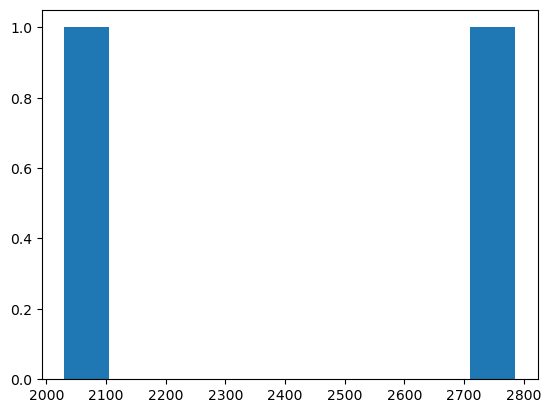

In [54]:
plt.hist(final_pred_post[final_pred_post>2000])

(array([358.,  56.,  18.,  12.,  10.,  12.,   5.,   9.,   4.,   7.]),
 array([2006. , 2805.3, 3604.6, 4403.9, 5203.2, 6002.5, 6801.8, 7601.1,
        8400.4, 9199.7, 9999. ]),
 <BarContainer object of 10 artists>)

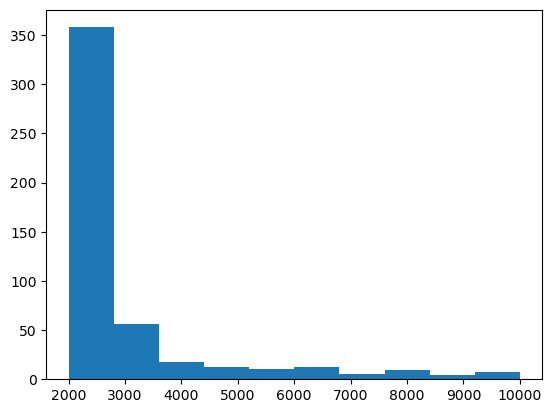

In [55]:
plt.hist(train.loc[train['Income']>2000, 'Income'])

In [56]:
# for i in range(1, 6):
#     with open(f'{model_path}/gbr_{i}.pkl', 'rb') as f:
#         gbr = pickle.load(f)

#     feature_importances = gbr.feature_importances_
#     importance_df = pd.Series(feature_importances[:20], index=trainval_x.columns[:20])
#     importance_df.sort_values(inplace=True)

#     plt.title(f'{i}fold_gbr')
#     plt.barh(np.arange(len(importance_df)), importance_df)
#     plt.yticks(np.arange(len(importance_df)), importance_df.index)
#     plt.show()

#     with open(f'{model_path}/rf_{i}.pkl', 'rb') as f:
#         rf = pickle.load(f)

#     feature_importances = rf.feature_importances_
#     importance_df = pd.Series(feature_importances[:20], index=trainval_x.columns[:20])
#     importance_df.sort_values(inplace=True)

#     plt.title(f'{i}fold_rf')
#     plt.barh(np.arange(len(importance_df)), importance_df)
#     plt.yticks(np.arange(len(importance_df)), importance_df.index)
#     plt.show()